# Header files

In [1]:
import re
import os 
import json
import cv2
import requests

import numpy as np
import scipy as sc
import pandas as pd 
import networkx as nx 
import matplotlib.pyplot as plt

from itertools import compress
from collections import Counter
from scipy.interpolate import Rbf
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

# File imports

In [2]:
all_datasets = ('Dataset1', 'Dataset2', 'Dataset3', 'Dataset4', 'Dataset5', 'Dataset6', 'Dataset7', 'Dataset8')

Node_name = ['ADFL','ADFR','ADLL','ADLR','AFDL','AFDR','ALML','ALMR','ALNL','ALNR','AQR','ASEL','ASER','ASGL','ASGR','ASHL','ASHR','ASIL','ASIR','ASJL','ASJR','ASKL','ASKR','AUAL','AUAR','AVM','AWAL','AWAR','AWBL','AWBR','AWCL','AWCR','BAGL','BAGR','DVA','FLPL','FLPR','IL2DL','IL2DR','IL2L','IL2R','IL2VL','IL2VR','OLLL','OLLR','OLQDL','OLQDR','OLQVL','OLQVR','PLNL','PLNR','SAADL','SAADR','SAAVL','SAAVR','SDQL','SDQR','URBL','URBR','URXL','URXR','URYDL','URYDR','URYVL','URYVR','ADAL','ADAR','AIAL','AIAR','AIBL','AIBR','AINL','AINR','AIYL','AIYR','AIZL','AIZR','AVAL','AVAR','AVBL',
             'AVBR','AVDL','AVDR','AVEL','AVER','AVJL','AVJR','BDUL','BDUR','PVCL','PVCR','PVPL','PVPR','PVR','PVT','RIAL','RIAR','RIBL','RIBR','RIFL','RIFR','RIGL','RIGR','RIH','RIML','RIMR','RIPL','RIPR','RIR','IL1DL','IL1DR','IL1L','IL1R','IL1VL','IL1VR','RIVL','RIVR','RMDDL','RMDDR','RMDL','RMDR','RMDVL','RMDVR','RMED','RMEL','RMER','RMEV','RMFL','RMFR','RMHL','RMHR','SIADL','SIADR','SIAVL','SIAVR','SIBDL','SIBDR','SIBVL','SIBVR','SMBDL','SMBDR','SMBVL','SMBVR','SMDDL','SMDDR','SMDVL','SMDVR','URADL','URADR','URAVL','URAVR','ADEL','ADER','AIML','AIMR','ALA','AVFL','AVFR','AVHL',
             'AVHR','AVKL','AVKR','AVL','CEPDL','CEPDR','CEPVL','CEPVR','DVC','HSNL','HSNR','PVNL','PVNR','PVQL','PVQR','RICL','RICR','RID','RIS','RMGL','RMGR','BWM-DL01','BWM-DR01','BWM-VL01','BWM-VR01','BWM-DL02','BWM-DR02','BWM-VL02','BWM-VR02','BWM-DL03','BWM-DR03','BWM-VL03','BWM-VR03','BWM-DL04','BWM-DR04','BWM-VL04','BWM-VR04','BWM-DL05','BWM-DR05','BWM-VL05','BWM-VR05','BWM-DL06','BWM-DR06','BWM-VL06','BWM-VR06','BWM-DL07','BWM-DR07','BWM-VL07','BWM-VR07','BWM-DL08','BWM-DR08','BWM-VL08','BWM-VR08','CANL','CANR','CEPshDL','CEPshDR','CEPshVL','CEPshVR','GLRDL','GLRDR','GLRL','GLRR','GLRVL','GLRVR']

Post_emb = ['ALNL','ALNR','AQR','AVM','PLNL','PLNR','SDQL','SDQR','RMFL','RMFR','RMHL','RMHR','AVFL','AVFR','HSNL','HSNR','PVNL','PVNR']

timepoint = {
    'Dataset1': 0,
    'Dataset2': 5,
    'Dataset3': 8,
    'Dataset4': 16,
    'Dataset5': 23,
    'Dataset6': 27,
    'Dataset7': 50,
    'Dataset8': 50,
}

stage = {   
    'Dataset1': 'L1',
    'Dataset2': 'L1',
    'Dataset3': 'L1',
    'Dataset4': 'L1',
    'Dataset5': 'L2',
    'Dataset6': 'L3',
    'Dataset7': 'Adult',
    'Dataset8': 'Adult'
}

larval_stage_ends = [0, 16, 25, 34, 45]
larval_stage_mids = [8, 20.5, 29.5, 39.5, 50]
larval_stage_labels = ['L1', 'L2', 'L3', 'L4', '  Adult']

categories = {
    'increase': 'Developmental change',
    'decrease': 'Developmental change',
    'stable': 'Stable',
    'noise': 'Variable',
    'remainder': 'Variable'
}

In [3]:
def nclass(n):
    if n in (
        'AVG', 'DVC', 'PVR', 'PVT', 'RIH', 'RIR', 'DVA', 'AQR', 'AVM', 'PQR',
        'PVM', 'DVB', 'PDA', 'PDB', 'ALA', 'AVL', 'RID', 'RIS',
        'I3', 'I4', 'I5', 'I5', 'M1', 'M4', 'M5', 'MI'
    ):
        return n
    if len(n) == 4 and n[-1] in 'LR' and n[:3] in (
        'ADA', 'ADE', 'ADF', 'ADL', 'AFD', 'AIA', 'AIB', 'AIM', 'AIN', 'AIY',
        'AIZ', 'ALM', 'ALN', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK', 'AUA',
        'AVA', 'AVB', 'AVD', 'AVE', 'AVF', 'AVH', 'AVJ', 'AVK', 'AWA', 'AWB',
        'AWC', 'BAG', 'BDU', 'CAN', 'FLP', 'GLR', 'HSN', 'IL1', 'IL2', 'LUA',
        'OLL', 'PDE', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PVC', 'PVD', 'PVN',
        'PVP', 'PVQ', 'PVW', 'RIA', 'RIB', 'RIC', 'RIF', 'RIG', 'RIM', 'RIP',
        'RIV', 'RMD', 'RMF', 'RMG', 'RMH', 'SDQ', 'URB', 'URX'
    ):
        return n[:3]
    if len(n) == 5 and n[-2:] in ('DL', 'DR', 'VL', 'VR') and n[:3] in (
        'CEP', 'GLR', 'IL1', 'IL2', 'OLQ', 'RMD', 'SAA', 'SIA', 'SIB', 'SMB',
        'SMD', 'URA', 'URY'
    ):
        return n[:3]
    if len(n) == 8 and re.match('BWM-[DV][LR]0[0-8]', n):
        return 'BWM' + n[-2:]
    if n in (
        'RMED', 'RMEL', 'RMER', 'RMEV', 'SABD', 'SABVL', 'SABVR',
    ):
        return n[:3]
    if n in (
        'CEPshDL', 'CEPshDR', 'CEPshVL', 'CEPshVR'
    ):
        return n[:5]
    if n[:2] in ('AS', 'VB', 'VA', 'VD') and n[2:] in map(str, range(12)):
        return n[:2] + 'n'
    if n in ('VA12', 'VD12', 'VD13'):
        return n[:2] + 'n'
    if re.match('^(DA[1-9])|(DB[1-7])|(DD[1-6])|(VC[1-6])$', n):
        return n[:2] + 'n'
    return n

def ntype(n):
    n = nclass(n)

    if n in (
        'ADF', 'ADL', 'AFD', 'ALM', 'ALN', 'AQR', 'ASE', 'ASG', 'ASH', 'ASI',
        'ASJ', 'ASK', 'AUA', 'AVM', 'AWA', 'AWB', 'AWC', 'BAG', 'DVA', 'FLP',
        'IL2', 'OLL', 'OLQ', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PQR', 'PVD',
        'PVM', 'SAA', 'SDQ', 'URB', 'URX', 'URY'
    ):
        return 'sensory'
    if n in (
        'ADA', 'AIA', 'AIB', 'AIN', 'AIY', 'AIZ', 'AVA', 'AVB', 'AVD', 'AVE',
        'AVG', 'BDU', 'LUA', 'PVC', 'PVP', 'PVR', 'PVT', 'PVW',
        'RIA', 'RIB', 'RIF', 'RIG', 'RIH', 'RIM', 'RIR', 'RIP', 'AVJ',
    ):
        return 'inter'
    if n in (
        'ASn', 'DAn', 'DBn', 'DDn', 'DVB', 'IL1', 'PDA', 'PDB', 'RIV', 'RMD',
        'RME', 'RMF', 'RMH', 'SAB', 'SIA', 'SIB', 'SMB', 'SMD', 'URA', 'VAn',
        'VBn', 'VCn', 'VDn',
    ):
        return 'motor'
    if n in (
        'ADE', 'AIM', 'ALA', 'AVF', 'AVH', 'AVK', 'AVL', 'CEP', 'HSN',
        'PDE', 'PVQ', 'PVN', 'RIC', 'RID', 'RIS', 'RMG', 'DVC',
    ):
        return 'modulatory'
    if n in (
        'BWM01', 'BWM02', 'BWM03', 'BWM04', 'BWM05', 'BWM06', 'BWM07', 'BWM08'
    ):
        return 'muscle'
    if n in ('CAN', 'CEPsh', 'GLR', 'excgl', 'hyp'):
        return 'other'
    print(n, 'is not a valid neuron')
    return 'nonvalid'

def npair(n):
    if n in (
        'AVG', 'DVC', 'PVR', 'PVT', 'RIH', 'RIR', 'DVA', 'AQR', 'AVM',
        'PQR',
        'PVM', 'DVB', 'PDA', 'PDB', 'ALA', 'AVL', 'RID', 'RIS',
        'I3', 'I4', 'I5', 'I5', 'M1', 'M4', 'M5', 'MI',
        'SABD', 'excgl'
    ):
        return n
    cls = nclass(n)
    if cls in (
        'ADA', 'AIA', 'AIB', 'AIN', 'AIY', 'AIZ', 'BDU', 'LUA', 'PVN', 'PVP',
        'PVW', 'RIA', 'RIB', 'RIF', 'RIG', 'RIM', 'RIP', 'AVA', 'AVD', 'AVE',
        'AVB', 'PVC', 'ADL', 'AFD', 'ASE', 'ASG', 'ASH', 'ASI', 'ASJ', 'ASK',
        'AUA', 'AWA', 'AWB', 'AWC', 'BAG', 'FLP', 'OLL', 'URB', 'RMG', 'PDE',
        'ALM', 'ALN', 'PHA', 'PHB', 'PHC', 'PLM', 'PLN', 'PVD', 'SDQ', 'RIV',
        'RMF', 'RMH', 'AIM', 'AVF', 'AVH', 'AVJ', 'AVK', 'PVQ', 'RIC', 'ADE',
        'ADF', 'HSN', 'URX',
        'I1', 'I2', 'M2', 'M3', 'MC', 'NSM',
        'CAN'
    ):
        return cls
    if cls in (
        'ASn', 'DAn', 'DBn', 'DDn', 'VAn', 'VBn', 'VCn', 'VDn'
    ):
        return n
    if cls in (
        'SAA', 'URY', 'SMB', 'SMD', 'URA', 'SIB', 'SIA', 'CEP', 'OLQ',
        'CEPsh'
    ):
        return n[:-1]
    if n[:-1] in (
        'SABV', 'IL1D', 'IL1V', 'IL2D', 'IL2V', 'RMDD', 'RMDV', 'GLRD',
        'GLRV',
    ):
        return n[:-1]
    if n in (
        'IL1L', 'IL1R', 'IL2L', 'IL2R', 'RMDL', 'RMDR', 'GLRL', 'GLRR',
        'RMEL', 'RMER'
    ):
        return n[:3] + 'L/R'
    if n in ('RMED', 'RMEV'):
        return 'RMED/V'

    if len(n) == 8 and re.match('BWM-[DV][LR]0[0-8]', n):
        return 'BWM' + n[-2:] + n[4]

    print(n, 'is not a valid cell?')

    return n

def contralateral(n):
    if nclass(n) == n:
        return n
    if n == 'RMED':
        return 'RMEV'
    if n == 'RMEV':
        return 'RMED'
    c = {'L': 'R', 'R': 'L'}
    if n.endswith('R') or n.endswith('L'):
        return n[:-1] + c[n[-1]]
    if n.startswith('BWM-'):
        return 'BWM-' + n[4] + c[n[5]] + n[6:] 
    return n

In [4]:
def convert_json_pandas(datasets=all_datasets):
    synapses_one_to_one = []

    synapses = {d: [] for d in datasets}
    for dataset in datasets:

        url = f"https://raw.githubusercontent.com/samarth1107/Network-Analysis-CElegan-Synapse/main/synapse_dataset/{dataset}_synapses.json"
        dataset_synapses = requests.get(url).json()

        # path = f"E:/Project/Network Bio/Paper/Network-Analysis-CElegan-Synapse/synapse_dataset/{dataset}_synapses.json"
        # dataset_synapses = json.load(open(path))
        
        for synapse in dataset_synapses:
            if synapse['pre'] not in Node_name:
                continue

            valid_posts = [n for n in synapse['post'] if n in Node_name]
            if len(valid_posts) == 0:
                continue

            if 'post_weights' in synapse:
                valid_post_weigths = []
                for valid_post in valid_posts:
                    post_idx = synapse['post'].index(valid_post)
                    valid_post_weigths.append(synapse['post_weights'][post_idx])
                synapse['post_weights'] = valid_post_weigths

            synapse['post'] = valid_posts

            synapses[dataset].append(synapse)


    for dataset in datasets:
        for i, raw_synapse in enumerate(synapses[dataset]):
            pre = raw_synapse['pre']
            for post_idx, (post, post_tid) in enumerate(
                    zip(raw_synapse['post'], raw_synapse['post_tid'])):
                if pre not in Node_name or post not in Node_name:
                    continue

                synapse = {
                    'dataset': dataset,
                    'pre': pre, 
                    'post': post,
                }

                synapses_one_to_one.append(synapse)

    synapses_one_to_one = pd.DataFrame(synapses_one_to_one)

    synapses_one_to_one['count'] = 1
    connections = synapses_one_to_one.groupby(['pre', 'post', 'dataset'], as_index=False).sum().set_index(['pre', 'post']).pivot(columns='dataset')

    connections['count']
    connections = connections.fillna(0).astype(int)

    cols = sorted(connections.columns)
    connections = connections[cols]

    return connections['count']

In [5]:
connection_data = convert_json_pandas()

data = []
data.append('Synapse raw data')

Dataset_url = 'https://github.com/samarth1107/Network-Analysis-CElegan-Synapse/blob/main/synapse_data.xlsx?raw=true'
# Dataset_url = 'E:/Project/Network Bio/Paper/Network-Analysis-CElegan-Synapse/synapse_data.xlsx'
for dataset_number in range(1, 9):
    data.append(pd.read_excel(Dataset_url, sheet_name=f"Dataset{dataset_number}", 
                              index_col=0, header=2, 
                              skiprows=[3], usecols=range(2,183)))
    for i in Node_name[180:]:
        data[-1][i] = 0

nx_G = []
nx_G.append('Synapse networkx data')

for dataset_number in range(1, 9):    
    nx_G.append(nx.from_numpy_matrix(data[dataset_number].T.values, create_using=nx.DiGraph))
    
# for dataset_number in range(1, 9):
#     nx.write_gml(nx_G[dataset_number], f'network{dataset_number}.gml')

# Functions

In [6]:
def plot_graph(data, yticks, y_name, size=3, smooth_line=True, multiple_graphs=False, legend=None):
    fig, ax = plt.subplots(figsize=(size, size*0.75), dpi=150)
       
    x_ticks = list(timepoint.values())   
    if multiple_graphs:
      for index in range(len(data)):
        plt.scatter(x_ticks, data[index], zorder=2, label=legend[index])
    else:  
      plt.scatter(x_ticks, data, zorder=2)
    
    min_x = 0
    max_x = 50

    if smooth_line:
      x_new = np.linspace(min_x, max_x, 100)
      rbf = Rbf(x_ticks, data, function = 'thin_plate', smooth = 0.1)
      y_smooth = rbf(x_new)
      plt.plot(x_new, y_smooth, zorder=1, color='black')
    else:
      if multiple_graphs:
        for dat in data:
          plt.plot(x_ticks, dat, zorder=1, color='black')
      else:  
        plt.plot(x_ticks, data, zorder=1, color='black')

    ax.set_xlim([min_x-5, max_x+5])
    ax.set_xticks([min_x-5])
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_xticks(larval_stage_mids, minor=True)
    ax.set_xticklabels(larval_stage_labels, minor=True)
    ax.tick_params(axis='x', which='minor', bottom=False, pad=1)
    
    for t in larval_stage_ends:
        plt.axvline(t, color='#999999', linestyle='dotted', linewidth=1, zorder=-1)

    if multiple_graphs:
        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    ax.set_yticks(yticks)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    
    plt.ylabel(y_name)
    plt.xlabel('Developmental age')
    plt.show()

def remove_postemb(df):
    df = df.copy()
    n1_postemb = df.index.get_level_values(0).isin(Post_emb)
    n2_postemb = df.index.get_level_values(1).isin(Post_emb)
    return df[~n1_postemb & ~n2_postemb]

def remove_noise(df):
    df = df.copy()
    noise_edges = []
    for pre, post in df.index:
        edge = pre, post
        edge_c = (contralateral(pre), contralateral(post))
        syns = df.loc[edge]
        if edge != edge_c and edge_c in df.index:
            syns_c = df.loc[edge_c]
        else:
            syns_c = np.zeros(df.shape[1])

        if (syns >= 2).sum() >= 2:
            continue
        if any((syns >= 1) & (syns_c >= 2)):
            continue
        if any((syns >= 2) & (syns_c >= 1)):
            continue

        noise_edges.append(edge)

    return df.drop(noise_edges)

def to_npair(df):
    df = df.copy()
    index_names = df.index.names
    temp_index_names = []
    for i, idx_name in enumerate(df.index.names):
        temp_index_name = idx_name + '_pair'
        temp_index_names.append(temp_index_name)
        df[temp_index_name] = df.index.get_level_values(i).map(npair)

    df_pair = df.groupby(temp_index_names).sum()
    df_pair.index.names = index_names
    return df_pair

def classify_edges(connection_data, datasets=all_datasets, edge_type='count'):
    G_postemb = connection_data.copy()
    G_postemb = G_postemb[(G_postemb.sum(axis=1) > 0)]
    G = remove_postemb(G_postemb)
    G_normalized = G / G.sum() * G.sum().mean()
    G_filtered = remove_noise(G)

    G_pair = to_npair(G)
    G_pair_normalized = to_npair(G_normalized)
    G_pair_filtered = to_npair(G_filtered)
    pair_edges_filtered = G_pair_filtered[G_pair_filtered.sum(axis=1) > 0].index
    pair_edges_all = G_pair[G_pair.sum(axis=1) > 0].index

    timepoints = [timepoint[d] for d in datasets]
    p_values = []
    for edge in pair_edges_filtered:
        synapses = G_normalized[G_normalized.index.map(lambda e: (npair(e[0]), npair(e[1])) == edge)]
        x = timepoints * synapses.shape[0]
        p_values.append(sc.stats.spearmanr(x, synapses.values.flatten()).pvalue)

    fdr = fdrcorrection0(p_values)
    significant_edges = list(compress(pair_edges_filtered, fdr[0]))

    classification = {
        'increase': [],
        'decrease': [],
    }
    for edge in significant_edges:
        syns_normalized = G_pair_normalized.loc[edge]
        juv = np.mean(syns_normalized[:2])
        mat = np.mean(syns_normalized[[d for d in datasets if stage[d] == 'Adult']])
        if mat > juv*5:
            classification['increase'].append(edge)
        elif juv > mat*5:
            classification['decrease'].append(edge)

    classification['stable'] = []
    for edge in G_pair_filtered.index:
        if edge in classification['increase'] or edge in classification['decrease']:
            continue
        if np.count_nonzero(G_pair.loc[edge]) >= len(datasets) - 1:
            classification['stable'].append(edge)


    classification['noise'] = [
        e for e in pair_edges_all if e not in pair_edges_filtered
    ]
    classification['remainder'] = [
        e for e in pair_edges_all if e not in [h for hs in classification.values() for h in hs]
    ]

    classifications = {}
    pair_classifications = {e: t for t in classification for e in classification[t]}
    for (pre, post) in G.index:
        classification = pair_classifications[npair(pre), npair(post)]
        if (pre, post) not in G_filtered.index:
            classification = 'noise'
        classifications[(pre, post)] = classification

    edge_classifications = pd.Series(classifications, name='edge_classifications')
    edge_classifications.index.set_names(['pre', 'post'], inplace=True)

    G_classifications = G.merge(edge_classifications, left_index=True, right_index=True)
    counts = G_classifications.groupby('edge_classifications').agg(lambda s: s.astype(bool).sum())
    counts.loc['all'] = counts.sum()
    return edge_classifications

def plot_stack_area(df, yticks, y_name, title, size=3):
    fig, ax = plt.subplots(figsize=(size, size*0.75), dpi=150)
    df = df.copy()
    df.loc['Stable']+=df.loc['Developmental change']
    df.loc['Variable']+=df.loc['Stable']

    colors = {
    'Variable': '#7293CB', 
    'Stable': '#E1974C',
    'Developmental change': '#84BA5B',
    'Variable edge': '#396AB1', 
    'Stable edge': '#DA7C30',
    'Developmental change edge': '#3E9651'
    }
        
    x_ticks = list(timepoint.values())     
    z_order = 1
    for neuron_type in ['Variable', 'Stable', 'Developmental change']:
      ax.plot(x_ticks, df.loc[neuron_type], zorder=z_order, color=colors[neuron_type+" edge"])
      ax.fill_between(x_ticks, df.loc[neuron_type], [0]*8, alpha=1, zorder=z_order, color=colors[neuron_type])
      ax.scatter(x_ticks, df.loc[neuron_type], zorder=z_order, color=colors[neuron_type+" edge"])
      z_order+=1

    min_x = 0
    max_x = 50
    ax.set_xlim([min_x-5, max_x+5])
    ax.set_xticks([min_x-5])
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_xticks(larval_stage_mids, minor=True)
    ax.set_xticklabels(larval_stage_labels, minor=True)
    ax.tick_params(axis='x', which='minor', bottom=False, pad=1)

    for t in larval_stage_ends:
        plt.axvline(t, color='#999999', linestyle='dotted', linewidth=1, zorder=-1)

    ax.set_yticks(yticks)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

    plt.ylabel(y_name)
    plt.xlabel('Developmental age')
    plt.title(title)
    plt.show()

def count_driver_neurons(graph):
    nodes = len(graph)
    G = nx.Graph()
    left_nodes = range(nodes)
    right_nodes = range(nodes, 2*nodes)
    G.add_nodes_from(left_nodes, bipartite=0)
    G.add_nodes_from(right_nodes, bipartite=1)
    for i in range(nodes):
        for j in range(nodes):
            if graph.iloc[j,i] > 0:
                G.add_edges_from([(i, nodes+j)])
    u = [n for n in G.nodes if G.nodes[n]['bipartite'] == 0]
    matching_edges = nx.bipartite.maximum_matching(G, top_nodes=u)
    matching_nodes = []
    for key in matching_edges:
        matching_nodes.append(matching_edges[key])
    count = 0
    driver_neurons = []
    for i in range(nodes):
        if i not in matching_nodes:
            count += 1
            driver_neurons.append(i)
    return count, driver_neurons

def feed_type(edge):
        edge_type = (ntype(edge[0]), ntype(edge[1]))
        if edge_type in (('sensory', 'inter'), ('inter', 'motor'), ('sensory', 'motor'), ('modulatory', 'inter'), ('sensory', 'modulatory'), ('modulatory', 'motor')):
            return 'Feed-forward'
        if edge_type in (('inter', 'sensory'), ('motor', 'inter'), ('motor', 'sensory'), ('inter', 'modulatory'), ('modulatory', 'sensory')):
            return 'Feed-back'
        if edge_type in (('sensory', 'sensory'), ('inter', 'inter'), ('motor', 'motor'), ('modulatory', 'modulatory')):
            return 'Recurrent'
        return None

def stacked_bar_plot(df, yticks, y_name, title, typeofgraph = 'connection_type', size=3, value_df=False):
    fig, ax = plt.subplots(figsize=(size, size*0.75), dpi=150)
       
    x_ticks = larval_stage_mids   

    if typeofgraph == 'connection_type':
        stacked_data = pd.DataFrame()
        if value_df:
            for dataset in all_datasets:
                stacked_data[dataset] = df[dataset].copy()
                stacked_data[dataset] = stacked_data[dataset]/stacked_data[dataset].sum()
        else:
            for dataset in all_datasets:
                stacked_data[dataset] = df[dataset].value_counts()
                stacked_data[dataset] = stacked_data[dataset]/stacked_data[dataset].sum()

        for dataset in stage.values():
            stacked_data[dataset] = 0
        for dataset in stage:
            stacked_data[stage[dataset]] += stacked_data[dataset]
        for dataset in stage.values():
            stacked_data[dataset] = stacked_data[dataset]*100/stacked_data[dataset].sum()
        stacked_data['L4'] = 0

        stacked_data = stacked_data[['L1','L2','L3','L4','Adult']].T
        ax.bar(x_ticks, stacked_data['motor'], width=3, label='motor')
        ax.bar(x_ticks, stacked_data['sensory'], bottom=stacked_data['motor'], width=3, label='sensory')
        ax.bar(x_ticks, stacked_data['inter'], bottom=stacked_data['motor']+stacked_data['sensory'], width=3, label='inter')
        ax.bar(x_ticks, stacked_data['modulatory'], bottom=stacked_data['motor']+stacked_data['sensory']+stacked_data['inter'], width=3, label='modulatory')
        # ax.bar(x_ticks, stacked_data['muscle'], bottom=stacked_data['motor']+stacked_data['sensory']+stacked_data['inter']+stacked_data['modulatory'], width=3, label='muscle')
        ax.bar(x_ticks, stacked_data['other'], bottom=stacked_data['motor']+stacked_data['sensory']+stacked_data['inter']+stacked_data['modulatory'], width=3, label='other')
    
    elif typeofgraph == 'feed_type':
        stacked_data = pd.DataFrame()
        for dataset in all_datasets:
            stacked_data[dataset] = df[dataset].T.copy()
        for dataset in stage.values():
            stacked_data[dataset] = 0
        for dataset in stage:
            stacked_data[stage[dataset]] += stacked_data[dataset]
        for dataset in stage.values():
            stacked_data[dataset] = stacked_data[dataset]*100/stacked_data[dataset].sum()
        stacked_data['L4'] = 0

        stacked_data = stacked_data[['L1','L2','L3','L4','Adult']].T
        ax.bar(x_ticks, stacked_data['Feed-back'], width=3, label='Feedback')
        ax.bar(x_ticks, stacked_data['Feed-forward'], bottom=stacked_data['Feed-back'], width=3, label='Feedforward')
        ax.bar(x_ticks, stacked_data['Recurrent'], bottom=stacked_data['Feed-back']+stacked_data['Feed-forward'], width=3, label='Recurrent')

    min_x = 0
    max_x = 50

    ax.set_xlim([min_x-5, max_x+5])
    ax.set_xticks([min_x-5])
    ax.tick_params(axis='x', labelbottom=False)
    ax.set_xticks(larval_stage_mids, minor=True)
    ax.set_xticklabels(larval_stage_labels, minor=True)
    ax.tick_params(axis='x', which='minor', bottom=False, pad=1)
    
    for t in larval_stage_ends:
        plt.axvline(t, color='#999999', linestyle='dotted', linewidth=1, zorder=-1)
    
    ax.set_yticks(yticks)
    ax.legend()
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.ylabel(y_name)
    plt.title(title)
    plt.xlabel('Developmental age')
    plt.show()


# Plots

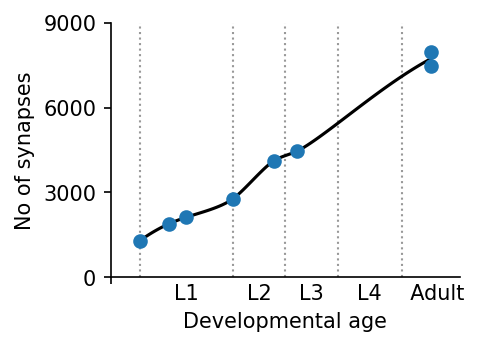

In [193]:
no_of_synapses = []
for dataset_number in range(1, 9):    
    no_of_synapses.append(sum(data[dataset_number].sum()))
plot_graph(no_of_synapses, [0,3000,6000,9000], 'No of synapses')

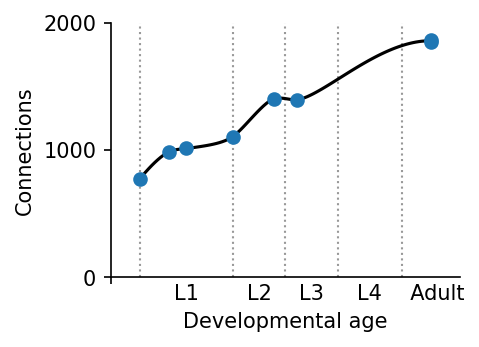

In [8]:
connection_data_postemb_remove = remove_postemb(connection_data)
connections = list(connection_data_postemb_remove.astype(bool).sum())
plot_graph(connections, [0,1000,2000], 'Connections')

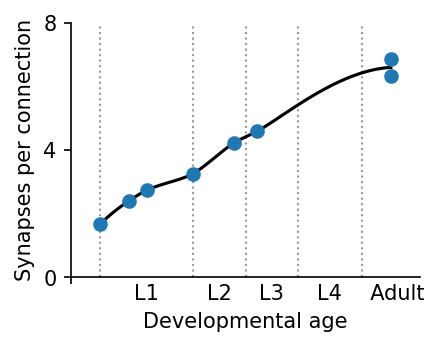

In [9]:
connection_data_postemb_remove = remove_postemb(connection_data)
connection_from_birth =  connection_data_postemb_remove[connection_data_postemb_remove['Dataset1'] > 0]
synapses_per_connection = list(connection_from_birth.apply(lambda s: s[s > 0].mean()))

plot_graph(synapses_per_connection, [0,4,8], 'Synapses per connection')

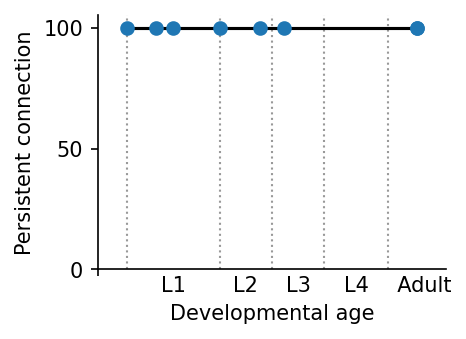

In [10]:
persistant_contact = []
persistant_contact.append(100)
for dataset_number in range(2, 9):    
  persistant_contact.append(np.sum(data[dataset_number][data[dataset_number-1]>0].count().values)*100/np.sum(data[dataset_number-1][data[dataset_number-1]>0].count().values))
plot_graph(persistant_contact, [0,50,100], 'Persistent connection', smooth_line=False)

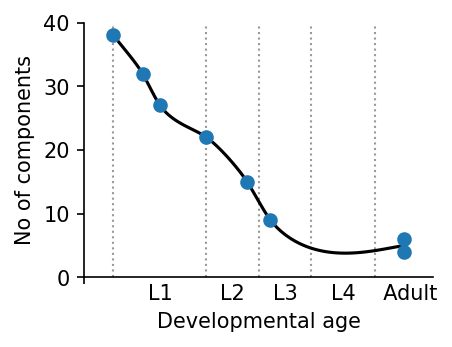

In [19]:
components=[]
for i in range(1,9):
    components.append(len(sorted(nx.connected_components(nx_G[i].to_undirected()))))
plot_graph(components, list(range(0,50,10)), 'No of components')

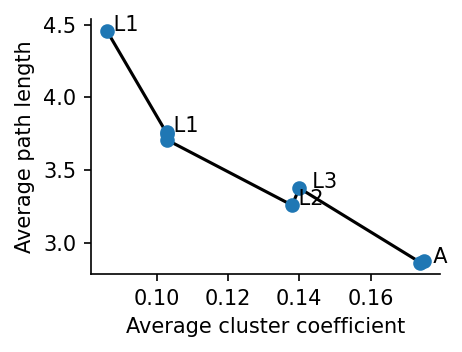

In [11]:
cytoscape_cluster_coeff =       [0.086,0.103,0.103,0.103,0.138,0.140,0.174,0.175]
cytoscape_average_path_length = [4.457,3.744,3.762,3.705,3.257,3.375,2.863,2.873]


fig, ax = plt.subplots(figsize=(3, 3*0.75), dpi=150)
ax.scatter(cytoscape_cluster_coeff, cytoscape_average_path_length, zorder=2)
ax.plot(cytoscape_cluster_coeff, cytoscape_average_path_length, zorder=1, color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)  

for i, txt in enumerate([' L1', '', ' L1', '', ' L2', '  L3', '  A', '']):
    ax.annotate(txt, (cytoscape_cluster_coeff[i], cytoscape_average_path_length[i]), fontsize=10)
    
plt.ylabel('Average path length')
plt.xlabel('Average cluster coefficient')
    
plt.show()

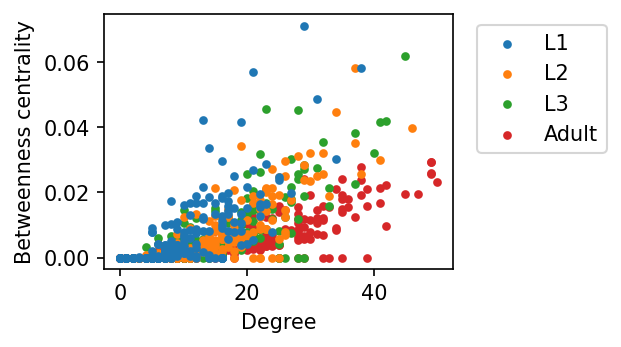

In [117]:
fig, ax = plt.subplots(figsize=(3, 3*0.75), dpi=150)
order=8
legend=['L1','L2','L3','Adult']
for index, dataset in enumerate([3,5,6,8]):      
    y = nx.betweenness_centrality(nx_G[dataset])
    x = dict(nx.degree(nx_G[dataset]))
    ax.scatter(x.values(), y.values(), label=legend[index], s=10, zorder=order)
    order -= 1
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Betweenness centrality')
plt.xlabel('Degree')
plt.show()

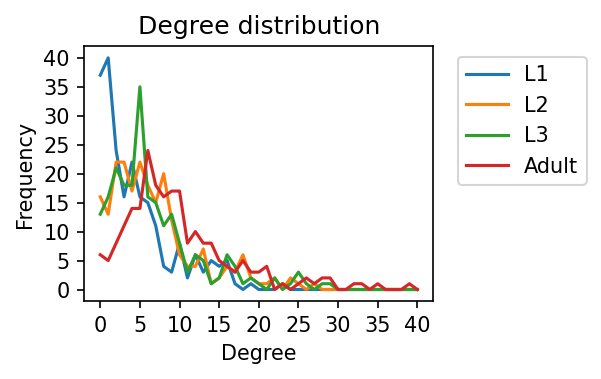

In [135]:
fig, ax = plt.subplots(figsize=(3, 3*0.75), dpi=150)
legend=['L1','L2','L3','Adult']
for index, i in enumerate([3,5,6,8]):      
    degrees = dict(nx_G[i].in_degree()).values()
    max_degree = 40
    xfreg = 5
    c = Counter(degrees)
    d = [0 for i in range(max_degree+1)]
    
    for i in range(max_degree+1): 
        d[i] = c[i]
        
    plt.plot(range(max_degree+1), d, label=legend[index])
    # plt.bar(range(max_degree+1), d)
    plt.xticks(range(0, max_degree+1, xfreg))
    plt.yticks(range(0, 41, 5))
    plt.gca().set(title='Degree distribution', ylabel='Frequency', xlabel="Degree")
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [14]:
connection_data_postemb_remove = remove_postemb(connection_data)
edge_classifications = classify_edges(connection_data_postemb_remove)
G_classifications = connection_data_postemb_remove.merge(edge_classifications.map(categories), left_index=True, right_index=True)
connections_count = G_classifications.groupby('edge_classifications').agg(lambda s: s.astype(bool).sum())
synapse_count = G_classifications.groupby('edge_classifications').sum()

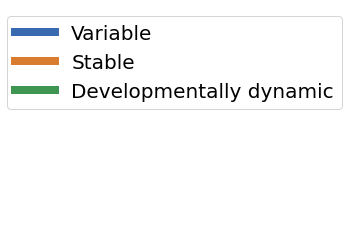

In [140]:
colors = {
    'Variable': '#7293CB', 
    'Stable': '#E1974C',
    'Developmental change': '#84BA5B',
    'Variable edge': '#396AB1', 
    'Stable edge': '#DA7C30',
    'Developmental change edge': '#3E9651'
}
# Create legend handles manually
line1, = plt.plot([1], label='Variable', color=colors['Variable edge'], linewidth=8)
line2, = plt.plot([1], label='Stable', color=colors['Stable edge'], linewidth=8)
line3, = plt.plot([1], label='Developmentally dynamic', color=colors['Developmental change edge'], linewidth=8)
plt.legend(handles=[line1, line2, line3], prop={'size': 20})
plt.gca().set_axis_off()
plt.show()

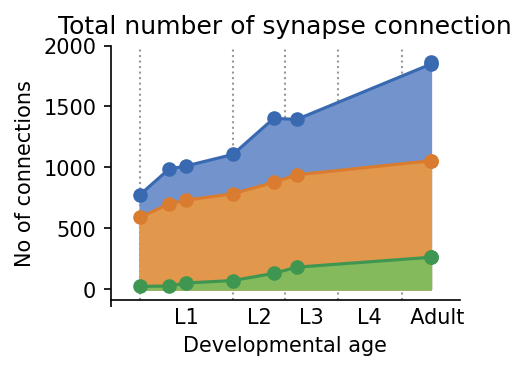

In [160]:
plot_stack_area(connections_count, range(0, 2500, 500), 'No of connections', 'Total number of synapse connection')

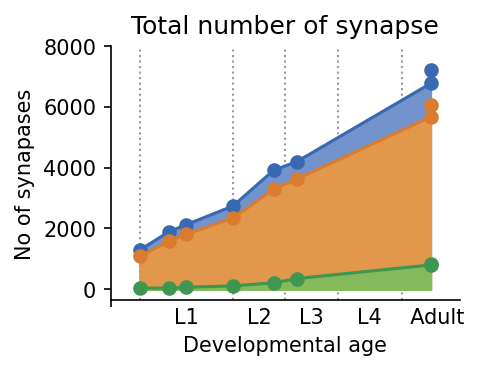

In [161]:
plot_stack_area(synapse_count, range(0, 8500, 2000), 'No of synapases', 'Total number of synapse')

In [49]:
feed_types = ['Feed-back', 'Feed-forward', 'Recurrent']
feed_type_data = connection_data_postemb_remove.copy()

feed_types=[]
for nfrom,nto in feed_type_data.index:
    feed_types.append(feed_type((nfrom, nto)))
feed_type_data['feed_types'] = feed_types
feed_type_counts = feed_type_data.groupby('feed_types').sum()
feed_type_counts = feed_type_counts / feed_type_counts.sum()

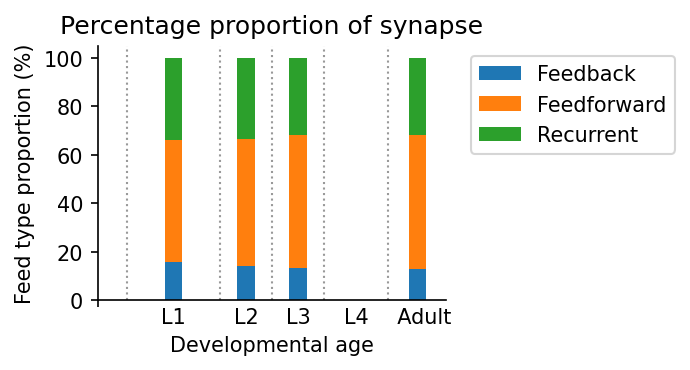

In [50]:
stacked_bar_plot(feed_type_counts, list(range(0,101,20)), 'Feed type proportion (%)', 'Percentage proportion of synapse', 'feed_type')

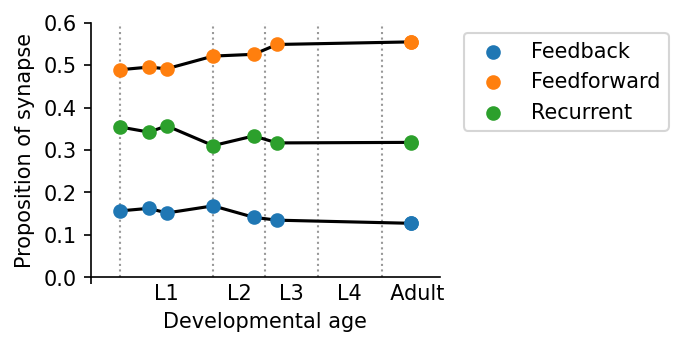

In [51]:
plot_graph([feed_type_counts.T['Feed-back'].values, feed_type_counts.T['Feed-forward'].values, feed_type_counts.T['Recurrent'].values], 
[0,0.1,0.2,0.3,0.4,0.5,0.6], 'Proposition of synapse', size=3, smooth_line=False, multiple_graphs=True,
legend=['Feedback','Feedforward','Recurrent'])

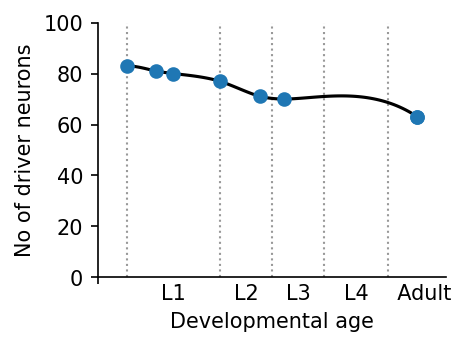

In [54]:
driver_neurons_count = []
driver_neurons_index = []

for dataset in range(1,9):
    a, b = count_driver_neurons(data[dataset])
    driver_neurons_count.append(a)
    driver_neurons_index.append(b)

driver_neurons_name = []
driver_neurons_type = []
for i in range(8):
    driver_neurons_name.append([Node_name[i] for i in driver_neurons_index[i]])
    driver_neurons_type.append([ntype(Node_name[i]) for i in driver_neurons_index[i]])

plot_graph(driver_neurons_count, list(range(0,101,20)), 'No of driver neurons')

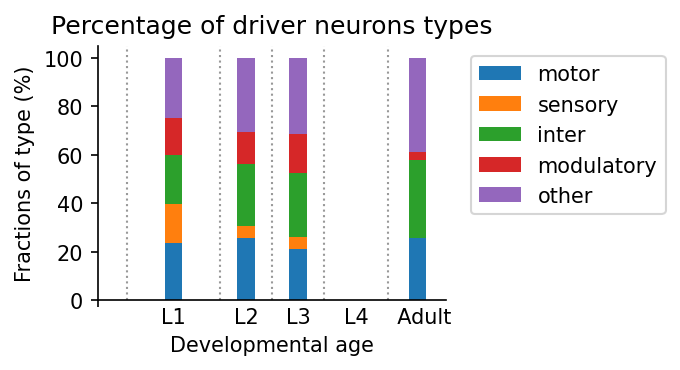

In [59]:
driver_neurons = pd.DataFrame()
driver_neurons['index'] = ['sensory','inter','motor','modulatory','muscle','other']
driver_neurons.set_index('index', inplace=True)
for dataset in all_datasets:
    values = dict(Counter(driver_neurons_type[int(dataset[-1])-1]))
    for key in values:
        driver_neurons.loc[key, dataset] = values[key]
driver_neurons.fillna(0, inplace=True)
driver_neurons.drop(['muscle'],axis=0)
stacked_bar_plot(driver_neurons.drop(['muscle'],axis=0), list(range(0,120,20)), 'Fractions of type (%)', 'Percentage of driver neurons types','connection_type', size=3, value_df=True)

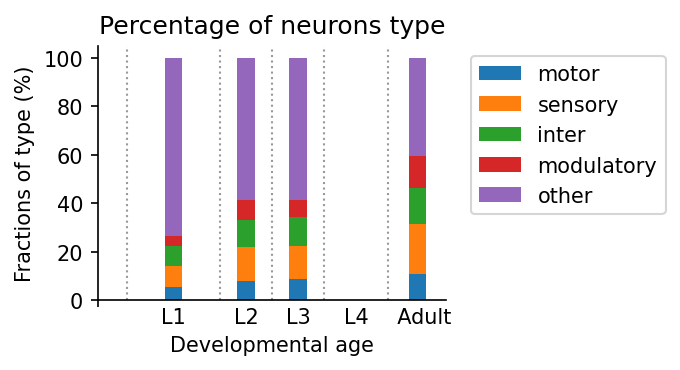

In [46]:
neuron_type = connection_data.copy()
for n_from, n_to in connection_data.index:
    for dataset in all_datasets:
        if neuron_type.loc[(n_from, n_to), dataset]>0:
            neuron_type.loc[(n_from, n_to), dataset] = ntype(n_from)
        else:
            neuron_type.loc[(n_from, n_to), dataset] = "other"

stacked_bar_plot(neuron_type, list(range(0,120,20)), 'Fractions of type (%)', 'Percentage of neurons type','connection_type')

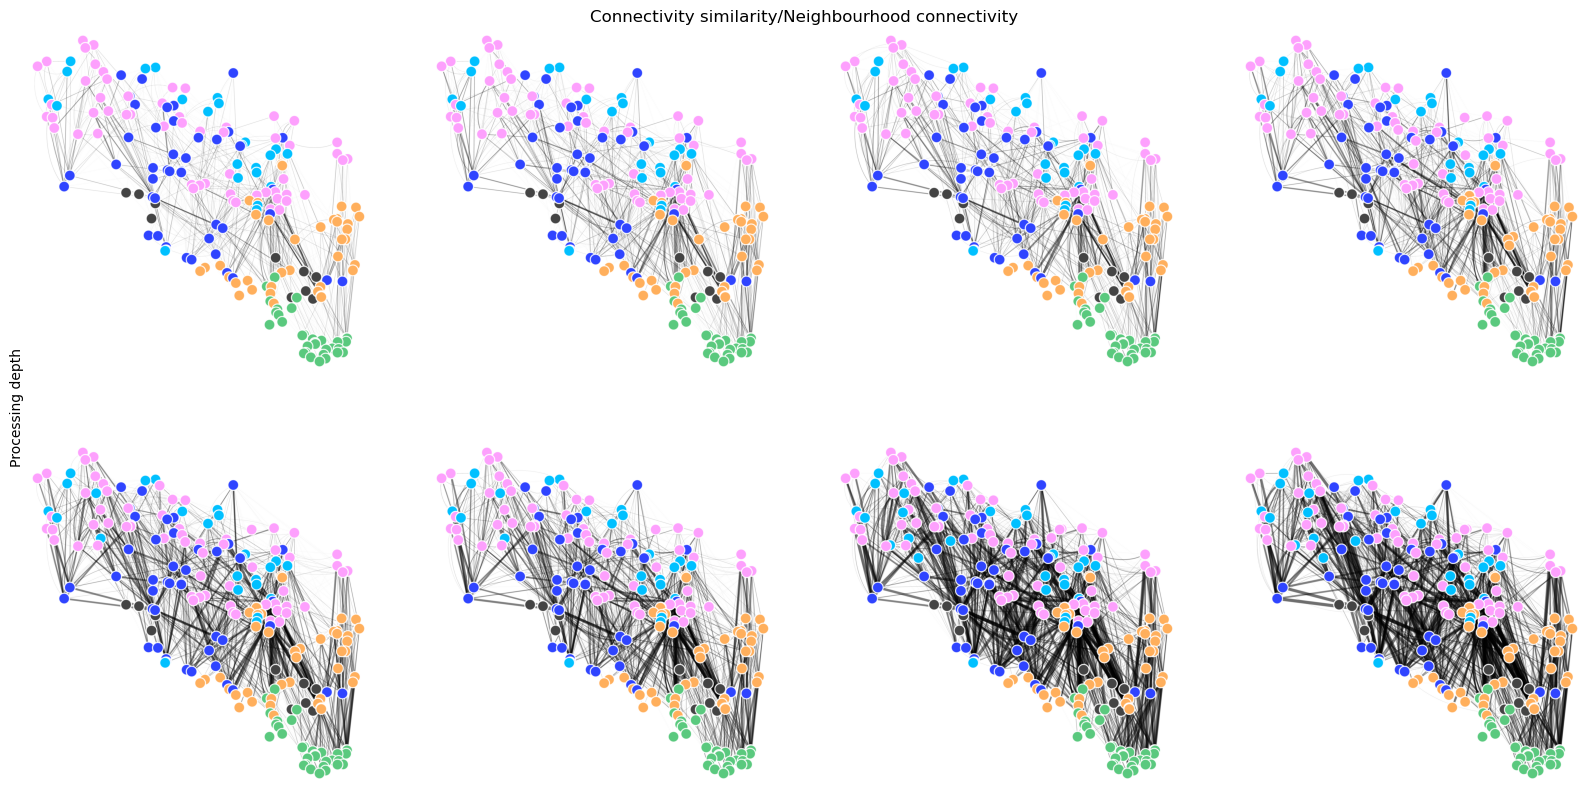

In [69]:
# Show images from cytoscape

fig, ax=plt.subplots(figsize=(20, 10), dpi=100)
plt.ylabel('Processing depth')
plt.title('Connectivity similarity/Neighbourhood connectivity')

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)   
ax.spines['left'].set_visible(False)   
ax.spines['bottom'].set_visible(False)   

Image1 = cv2.imread('E:/Project/Network Bio/Paper/1.png')
Image2 = cv2.imread('E:/Project/Network Bio/Paper/2.png')
Image3 = cv2.imread('E:/Project/Network Bio/Paper/3.png')
Image4 = cv2.imread('E:/Project/Network Bio/Paper/4.png')
Image5 = cv2.imread('E:/Project/Network Bio/Paper/5.png')
Image6 = cv2.imread('E:/Project/Network Bio/Paper/6.png')
Image7 = cv2.imread('E:/Project/Network Bio/Paper/7.png')
Image8 = cv2.imread('E:/Project/Network Bio/Paper/8.png')
  
fig.add_subplot(2, 4, 1)
plt.imshow(Image1)
plt.axis('off')

fig.add_subplot(2, 4, 2)
plt.imshow(Image2)
plt.axis('off')

fig.add_subplot(2, 4, 3)
plt.imshow(Image3)
plt.axis('off')

fig.add_subplot(2, 4, 4)
plt.imshow(Image4)
plt.axis('off')

fig.add_subplot(2, 4, 5)
plt.imshow(Image5)
plt.axis('off')

fig.add_subplot(2, 4, 6)
plt.imshow(Image6)
plt.axis('off')

fig.add_subplot(2, 4, 7)
plt.imshow(Image7)
plt.axis('off')

fig.add_subplot(2, 4, 8)
plt.imshow(Image8)
plt.axis('off')


plt.show()

# Extra